# ОИАД. Лабораторная работа №4 — Бинарная классификация

Датасет: `../../datasets/famcs_students.csv`

Цель: построить и сравнить несколько моделей бинарной классификации:
- тривиальный классификатор (самый частый класс);
- наивный байесовский классификатор (реализовать самим);
- метод k-ближайших соседей (реализовать самим, подобрать k);
- логистическая регрессия (реализовать самим, подобрать порог по F1).

Оценка качества на тестовой выборке по метрикам:
- accuracy, precision, recall, F1;
- ROC-AUC;
- матрица ошибок.

Ограничения: используем только `numpy`, `pandas`, `matplotlib` (и базовые модули Python). Алгоритмы классификации реализуем вручную, без моделей из `scikit-learn`.

## Краткая теория

Бинарная классификация: $y \in \{0,1\}$.

Метрики (для положительного класса 1):
- Accuracy = (TP+TN)/(TP+TN+FP+FN)
- Precision = TP/(TP+FP)
- Recall = TP/(TP+FN)
- F1 = 2PR/(P+R)
- ROC-AUC — площадь под ROC-кривой (TPR vs FPR).

Модели:
- Наивный Байес (Bernoulli): априоры классов и условные вероятности P(x_j=1|y=c).
- k-NN: голосование по k ближайшим соседям.
- Логистическая регрессия: P(y=1|x)=σ(w^T x), обучение по логистической потере градиентным спуском.

Порог классификации для логрега подбираем по максимуму F1 на валидации.

In [14]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from IPython.display import display

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

pd.set_option('display.max_columns', 200)
pd.set_option('display.width', 140)

## 0. Загрузка и подготовка данных

Используем файл `../../datasets/famcs_students.csv`.

Бинарные столбцы:
```python
binary_cols = [
    'ss', 'interest', 'weekend_study', 'bad_sleep',
    'glasses', 'anime', 'study_form', 'literature'
]
```

Целевая переменная: `y = binary_cols[N % 8]`, где `N` — 4, мой номер в списке группы.
Оставшиеся 7 бинарных признаков используем как `X` (не менее 5 признаков).

In [15]:
# Загрузка датасета
default_path = '../../datasets/famcs_students.csv'
alt_path = 'famcs_students.csv'

if os.path.exists(default_path):
    data_path = default_path
elif os.path.exists(alt_path):
    data_path = alt_path
else:
    data_path = None

if data_path is None:
    raise FileNotFoundError('Файл famcs_students.csv не найден. Проверьте путь ../../datasets/famcs_students.csv или положите файл рядом с ноутбуком.')

print('Используем файл:', data_path)
df = pd.read_csv(data_path)
print('Размерность данных:', df.shape)
display(df.head())
display(df.describe(include='all'))

Используем файл: ../../datasets/famcs_students.csv
Размерность данных: (127, 25)


,cource,group,stream,sex,age,ss,interest,os,weekend_study,bad_sleep,glasses,work_experience,ai,height,anime,social,sport,miss,study_form,foot_size,eye_color,score,retake,hostel,literature
0,4,11,Прикладная информатика,М,20.0,Нет,Математика,MacOS,Да,Да,Нет,Меньше года,Cursor,192.0,Нет,Экстраверт,"Редко, легкая физкультура",3.0,Бюджет,48.0,Карие,9.2,0,"Нет, я из Минска",Да
1,4,11,Прикладная информатика,Ж,20.0,Нет,Программирование,MacOS,Нет,Нет,Нет,1-2 года,Mistral,169.0,Нет,Экстраверт,"Да, я спортсмен",5.0,Бюджет,39.0,Зеленые,8.8,0,"Нет, я из Минска",Да
2,4,11,Прикладная информатика,Ж,19.0,Нет,Программирование,MacOS,Да,Нет,Нет,Меньше года,ChatGPT,190.0,Нет,Экстраверт,Вообще нет,10.0,Бюджет,41.0,Карие,8.8,0,"Нет, я из Минска",Да
3,4,11,Прикладная информатика,Ж,20.0,Нет,Математика,MacOS,Да,Да,Нет,1-2 года,Qwen,158.0,Нет,Экстраверт,"Да, я спортсмен",3.0,Бюджет,36.0,Карие,8.8,0,"Нет, я из Минска",Да
4,4,11,Прикладная информатика,М,20.0,Нет,Математика,Windows,Да,Нет,Нет,Не работаю,DeepSeek,187.0,Нет,Интроверт,Вообще нет,1.0,Бюджет,46.0,Зеленые,9.0,0,"Нет, я из Минска",Да


,cource,group,stream,sex,age,ss,interest,os,weekend_study,bad_sleep,glasses,work_experience,ai,height,anime,social,sport,miss,study_form,foot_size,eye_color,score,retake,hostel,literature
count,127.000000,127.000000,127,127,127.000000,127,127,127,127,127,127,127,127,127.000000,127,127,127,127.000000,127,127.000000,127,127.000000,127,127,127
unique,NaN,NaN,3,2,NaN,2,2,3,2,2,2,4,13,NaN,2,3,3,NaN,2,NaN,4,NaN,3,3,2
top,NaN,NaN,Информатика,М,NaN,Нет,Программирование,Windows,Да,Да,Да,Не работаю,ChatGPT,NaN,Нет,Интроверт,"Редко, легкая физкультура",NaN,Бюджет,NaN,Карие,NaN,0,"Нет, я из Минска",Да
freq,NaN,NaN,75,85,NaN,113,103,76,99,90,68,48,51,NaN,73,62,64,NaN,94,NaN,49,NaN,111,61,79
mean,3.952756,6.118110,NaN,NaN,20.433071,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,178.751969,NaN,NaN,NaN,7.850394,NaN,41.953741,NaN,7.555433,NaN,NaN,NaN
std,0.213001,4.460789,NaN,NaN,1.394949,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.360222,NaN,NaN,NaN,8.716276,NaN,3.389107,NaN,1.460913,NaN,NaN,NaN
min,3.000000,1.000000,NaN,NaN,16.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.000000,NaN,NaN,NaN,0.000000,NaN,34.125120,NaN,0.000000,NaN,NaN,NaN
25%,4.000000,2.000000,NaN,NaN,20.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,170.000000,NaN,NaN,NaN,3.000000,NaN,39.000000,NaN,7.000000,NaN,NaN,NaN
50%,4.000000,4.000000,NaN,NaN,20.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,179.000000,NaN,NaN,NaN,5.000000,NaN,42.000000,NaN,7.600000,NaN,NaN,NaN
75%,4.000000,11.000000,NaN,NaN,21.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,187.000000,NaN,NaN,NaN,10.000000,NaN,45.000000,NaN,8.450000,NaN,NaN,NaN


### Выбор целевой переменной и признаков

Установите `N` равным вашему номеру в списке группы. Цель: `y = binary_cols[N % 8]`. Остальные из `binary_cols` — признаки `X`.

In [16]:
binary_cols = [
    'ss', 'interest', 'weekend_study', 'bad_sleep',
    'glasses', 'anime', 'study_form', 'literature'
]

# Преобразуем все бинарные столбцы в 0/1
# 1.1 Да/Нет-колонки
yes_no_cols = ['ss', 'weekend_study', 'bad_sleep', 'glasses', 'anime', 'literature']

for col in yes_no_cols:
    if col not in df.columns:
        print(f'Предупреждение: столбец {col} отсутствует в df')
        continue
    df[col] = df[col].astype(str).str.strip()
    df[col] = df[col].map({'Нет': 0, 'Да': 1})
    # если есть пропуски/другие значения — считаем их как 0 (\"Нет\")
    df[col] = df[col].fillna(0).astype(int)

# 1.2 interest: Математика / Программирование
if 'interest' in df.columns:
    df['interest'] = df['interest'].astype(str).str.strip()
    df['interest'] = df['interest'].map({'Математика': 0, 'Программирование': 1})
    # если вдруг есть пропуски — считаем как 0 (например, Математика)
    df['interest'] = df['interest'].fillna(0).astype(int)

# 1.3 study_form: Бюджет / Платная
if 'study_form' in df.columns:
    df['study_form'] = df['study_form'].astype(str).str.strip()
    df['study_form'] = df['study_form'].map({'Бюджет': 0, 'Платная': 1})
    # пропуски считаем как 0 (Бюджет)
    df['study_form'] = df['study_form'].fillna(0).astype(int)

print('Проверка уникальных значений после маппинга:')
for col in binary_cols:
    if col in df.columns:
        print(col, '->', df[col].unique())
print()

N = 4

target_col = binary_cols[N % 8]
feature_cols = [c for c in binary_cols if c != target_col]

print('Целевая переменная (y):', target_col)
print('Признаки (X):', feature_cols)

missing = [c for c in [target_col] + feature_cols if c not in df.columns]
if missing:
    raise ValueError('В датасете отсутствуют необходимые столбцы: ' + ', '.join(missing))

df_sub = df[feature_cols + [target_col]].copy()
display(df_sub.head())

y_raw = df_sub[target_col]
unique_y = sorted(y_raw.dropna().unique())
print('Уникальные значения целевой переменной до преобразования:', unique_y)

if set(unique_y) == {0, 1}:
    y = y_raw.values.astype(int)
elif len(unique_y) == 2:
    mapping = {unique_y[0]: 0, unique_y[1]: 1}
    print('Преобразуем целевую переменную по маппингу:', mapping)
    y = y_raw.map(mapping).values.astype(int)
else:
    raise ValueError('Целевая переменная не бинарная (не 2 уникальных значения).')

X = df_sub[feature_cols].astype(float).values
print('Форма X:', X.shape, 'Форма y:', y.shape)
print('Частоты классов y:', Counter(y))

Проверка уникальных значений после маппинга:
ss -> [0 1]
interest -> [0 1]
weekend_study -> [1 0]
bad_sleep -> [1 0]
glasses -> [0 1]
anime -> [0 1]
study_form -> [0 1]
literature -> [1 0]

Целевая переменная (y): glasses
Признаки (X): ['ss', 'interest', 'weekend_study', 'bad_sleep', 'anime', 'study_form', 'literature']


,ss,interest,weekend_study,bad_sleep,anime,study_form,literature,glasses
0,0,0,1,1,0,0,1,0
1,0,1,0,0,0,0,1,0
2,0,1,1,0,0,0,1,0
3,0,0,1,1,0,0,1,0
4,0,0,1,0,0,0,1,0


Уникальные значения целевой переменной до преобразования: [np.int64(0), np.int64(1)]
Форма X: (127, 7) Форма y: (127,)
Частоты классов y: Counter({np.int64(1): 68, np.int64(0): 59})


## Разбиение на train / val / test

Требуемые доли:
- train — 70%;
- val — 15%;
- test — 15%.

Сделаем одно разбиение и будем использовать его для всех моделей.

In [17]:
def train_val_test_split(X, y, train_size=0.7, val_size=0.15, test_size=0.15, random_state=RANDOM_STATE):
    assert abs(train_size + val_size + test_size - 1.0) < 1e-8, 'Сумма долей должна быть 1'
    n = X.shape[0]
    idx = np.arange(n)
    rng = np.random.RandomState(random_state)
    rng.shuffle(idx)
    train_end = int(n * train_size)
    val_end = train_end + int(n * val_size)
    train_idx = idx[:train_end]
    val_idx = idx[train_end:val_end]
    test_idx = idx[val_end:]
    X_train, y_train = X[train_idx], y[train_idx]
    X_val, y_val = X[val_idx], y[val_idx]
    X_test, y_test = X[test_idx], y[test_idx]
    return X_train, X_val, X_test, y_train, y_val, y_test

X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(X, y, 0.7, 0.15, 0.15, random_state=RANDOM_STATE)

print('Train shape:', X_train.shape, 'Val shape:', X_val.shape, 'Test shape:', X_test.shape)
print('Train class counts:', Counter(y_train))
print('Val class counts:', Counter(y_val))
print('Test class counts:', Counter(y_test))

Train shape: (88, 7) Val shape: (19, 7) Test shape: (20, 7)
Train class counts: Counter({np.int64(1): 52, np.int64(0): 36})
Val class counts: Counter({np.int64(0): 11, np.int64(1): 8})
Test class counts: Counter({np.int64(0): 12, np.int64(1): 8})


## Вспомогательные функции для метрик и ROC-AUC

        Реализуем:
- confusion_matrix;
- accuracy, precision, recall, F1;
- ROC-кривую и ROC-AUC;
- функцию `evaluate_model`, печатающую все метрики и матрицу ошибок.

In [18]:
def confusion_matrix_binary(y_true, y_pred):
    y_true = np.asarray(y_true).astype(int)
    y_pred = np.asarray(y_pred).astype(int)
    TP = np.sum((y_true == 1) & (y_pred == 1))
    TN = np.sum((y_true == 0) & (y_pred == 0))
    FP = np.sum((y_true == 0) & (y_pred == 1))
    FN = np.sum((y_true == 1) & (y_pred == 0))
    return np.array([[TN, FP], [FN, TP]])

def accuracy_score(y_true, y_pred):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    return float(np.mean(y_true == y_pred))

def precision_score(y_true, y_pred):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    TP = np.sum((y_true == 1) & (y_pred == 1))
    FP = np.sum((y_true == 0) & (y_pred == 1))
    if TP + FP == 0:
        return 0.0
    return TP / (TP + FP)

def recall_score(y_true, y_pred):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    TP = np.sum((y_true == 1) & (y_pred == 1))
    FN = np.sum((y_true == 1) & (y_pred == 0))
    if TP + FN == 0:
        return 0.0
    return TP / (TP + FN)

def f1_score(y_true, y_pred):
    p = precision_score(y_true, y_pred)
    r = recall_score(y_true, y_pred)
    if p + r == 0:
        return 0.0
    return 2 * p * r / (p + r)

def roc_curve_binary(y_true, y_score):
    y_true = np.asarray(y_true).astype(int)
    y_score = np.asarray(y_score).astype(float)
    desc_idx = np.argsort(-y_score)
    y_true_sorted = y_true[desc_idx]
    P = np.sum(y_true_sorted == 1)
    N = np.sum(y_true_sorted == 0)
    if P == 0 or N == 0:
        return np.array([0.0, 1.0]), np.array([0.0, 1.0])
    TPR = [0.0]
    FPR = [0.0]
    TP = 0
    FP = 0
    for i in range(len(y_true_sorted)):
        if y_true_sorted[i] == 1:
            TP += 1
        else:
            FP += 1
        TPR.append(TP / P)
        FPR.append(FP / N)
    return np.array(FPR), np.array(TPR)

def roc_auc_score_binary(y_true, y_score):
    FPR, TPR = roc_curve_binary(y_true, y_score)
    order = np.argsort(FPR)
    FPR = FPR[order]
    TPR = TPR[order]
    return float(np.trapezoid(TPR, FPR))

def evaluate_model(y_true, y_pred, y_score, model_name='model'):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    auc = roc_auc_score_binary(y_true, y_score)
    cm = confusion_matrix_binary(y_true, y_pred)
    print(f'=== {model_name} ===')
    print(f'Accuracy : {acc:.4f}')
    print(f'Precision: {prec:.4f}')
    print(f'Recall   : {rec:.4f}')
    print(f'F1       : {f1:.4f}')
    print(f'ROC-AUC  : {auc:.4f}')
    print('Confusion matrix (rows: true [0,1]; cols: pred [0,1]):')
    print(cm)
    print()
    return {
        'model': model_name,
        'accuracy': acc,
        'precision': prec,
        'recall': rec,
        'f1': f1,
        'roc_auc': auc
    }

## 0. Тривиальный классификатор

Классификатор, всегда предсказывающий самый частый класс на train. Служит baseline.

In [19]:
class MostFrequentClassifier:
    def __init__(self):
        self.most_common_class = 0
        self.pos_prob = 0.0
    def fit(self, y):
        y = np.asarray(y).astype(int)
        counts = Counter(y)
        self.most_common_class = 1 if counts[1] >= counts[0] else 0
        self.pos_prob = counts[1] / (counts[0] + counts[1])
        return self
    def predict(self, X):
        n = X.shape[0]
        return np.full(n, self.most_common_class, dtype=int)
    def predict_proba(self, X):
        n = X.shape[0]
        pos = np.full(n, self.pos_prob, dtype=float)
        neg = 1.0 - pos
        return np.vstack([neg, pos]).T

baseline_clf = MostFrequentClassifier().fit(y_train)
y_test_pred_baseline = baseline_clf.predict(X_test)
y_test_score_baseline = baseline_clf.predict_proba(X_test)[:, 1]
baseline_results = evaluate_model(y_test, y_test_pred_baseline, y_test_score_baseline, model_name='Baseline (most frequent)')

=== Baseline (most frequent) ===
Accuracy : 0.4000
Precision: 0.4000
Recall   : 1.0000
F1       : 0.5714
ROC-AUC  : 0.5938
Confusion matrix (rows: true [0,1]; cols: pred [0,1]):
[[ 0 12]
 [ 0  8]]



## 1. Наивный байесовский классификатор (Bernoulli NB)

In [20]:
class BernoulliNaiveBayes:
    def __init__(self, alpha=1.0):
        self.alpha = alpha
        self.class_prior_ = None
        self.feature_log_prob_ = None
        self.feature_log_prob_neg_ = None
    def fit(self, X, y):
        X = np.asarray(X).astype(int)
        y = np.asarray(y).astype(int)
        n_samples, n_features = X.shape
        counts = Counter(y)
        total = n_samples
        self.class_prior_ = np.array([
            (counts[0] + self.alpha) / (total + 2 * self.alpha),
            (counts[1] + self.alpha) / (total + 2 * self.alpha)
        ])
        self.feature_log_prob_ = np.zeros((2, n_features))
        self.feature_log_prob_neg_ = np.zeros((2, n_features))
        for c in [0, 1]:
            X_c = X[y == c]
            n_c = X_c.shape[0]
            count_ones = X_c.sum(axis=0)
            p_1 = (count_ones + self.alpha) / (n_c + 2 * self.alpha)
            p_0 = 1.0 - p_1
            self.feature_log_prob_[c, :] = np.log(p_1)
            self.feature_log_prob_neg_[c, :] = np.log(p_0)
        return self
    def predict_proba(self, X):
        X = np.asarray(X).astype(int)
        n_samples, n_features = X.shape
        log_prior = np.log(self.class_prior_)
        log_likelihood = np.zeros((n_samples, 2))
        for c in [0, 1]:
            lp1 = self.feature_log_prob_[c]
            lp0 = self.feature_log_prob_neg_[c]
            ll = (X * lp1 + (1 - X) * lp0).sum(axis=1)
            log_likelihood[:, c] = ll
        log_posterior = log_likelihood + log_prior
        max_log = np.max(log_posterior, axis=1, keepdims=True)
        exp_shifted = np.exp(log_posterior - max_log)
        probs = exp_shifted / exp_shifted.sum(axis=1, keepdims=True)
        return probs
    def predict(self, X, threshold=0.5):
        probs = self.predict_proba(X)
        pos = probs[:, 1]
        return (pos >= threshold).astype(int)

nb_clf = BernoulliNaiveBayes(alpha=1.0).fit(X_train, y_train)
y_val_score_nb = nb_clf.predict_proba(X_val)[:, 1]
y_val_pred_nb = (y_val_score_nb >= 0.5).astype(int)
print('Наивный Байес (валидация):')
evaluate_model(y_val, y_val_pred_nb, y_val_score_nb, model_name='Naive Bayes (val)')

y_test_score_nb = nb_clf.predict_proba(X_test)[:, 1]
y_test_pred_nb = (y_test_score_nb >= 0.5).astype(int)
nb_results = evaluate_model(y_test, y_test_pred_nb, y_test_score_nb, model_name='Naive Bayes (test)')

Наивный Байес (валидация):
=== Naive Bayes (val) ===
Accuracy : 0.2105
Precision: 0.2308
Recall   : 0.3750
F1       : 0.2857
ROC-AUC  : 0.2273
Confusion matrix (rows: true [0,1]; cols: pred [0,1]):
[[ 1 10]
 [ 5  3]]

=== Naive Bayes (test) ===
Accuracy : 0.4500
Precision: 0.4000
Recall   : 0.7500
F1       : 0.5217
ROC-AUC  : 0.5000
Confusion matrix (rows: true [0,1]; cols: pred [0,1]):
[[3 9]
 [2 6]]



## 2. Метод k-ближайших соседей (k-NN)

Расстояние: Hamming (для бинарных признаков). Подбор k по F1 на валидации, порог 0.5.

In [21]:
class KNNClassifier:
    def __init__(self, k=5):
        self.k = k
        self.X_train = None
        self.y_train = None
    def fit(self, X, y):
        self.X_train = np.asarray(X).astype(float)
        self.y_train = np.asarray(y).astype(int)
        return self
    def _predict_single(self, x):
        diffs = np.abs(self.X_train - x)
        dists = diffs.sum(axis=1)
        nn_idx = np.argsort(dists)[:self.k]
        nn_labels = self.y_train[nn_idx]
        return nn_labels.mean()
    def predict_proba(self, X):
        X = np.asarray(X).astype(float)
        probs_pos = np.array([self._predict_single(x) for x in X])
        probs_neg = 1.0 - probs_pos
        return np.vstack([probs_neg, probs_pos]).T
    def predict(self, X, threshold=0.5):
        probs = self.predict_proba(X)
        pos = probs[:, 1]
        return (pos >= threshold).astype(int)

candidate_ks = [1, 3, 5, 7, 9, 11, 15, 21]
best_k = None
best_f1 = -1
for k in candidate_ks:
    knn = KNNClassifier(k=k).fit(X_train, y_train)
    y_val_score_knn = knn.predict_proba(X_val)[:, 1]
    y_val_pred_knn = (y_val_score_knn >= 0.5).astype(int)
    f1 = f1_score(y_val, y_val_pred_knn)
    print(f'k={k}: F1 (val) = {f1:.4f}')
    if f1 > best_f1:
        best_f1 = f1
        best_k = k
print('\nЛучшее k по F1 на валидации:', best_k, ', F1 =', best_f1)

knn_best = KNNClassifier(k=best_k).fit(X_train, y_train)
y_test_score_knn = knn_best.predict_proba(X_test)[:, 1]
y_test_pred_knn = (y_test_score_knn >= 0.5).astype(int)
knn_results = evaluate_model(y_test, y_test_pred_knn, y_test_score_knn, model_name=f'k-NN (k={best_k}) (test)')

k=1: F1 (val) = 0.6667
k=3: F1 (val) = 0.4762
k=5: F1 (val) = 0.3810
k=7: F1 (val) = 0.4348
k=9: F1 (val) = 0.4348
k=11: F1 (val) = 0.3158
k=15: F1 (val) = 0.2857
k=21: F1 (val) = 0.2353

Лучшее k по F1 на валидации: 1 , F1 = 0.6666666666666667
=== k-NN (k=1) (test) ===
Accuracy : 0.5500
Precision: 0.4667
Recall   : 0.8750
F1       : 0.6087
ROC-AUC  : 0.6458
Confusion matrix (rows: true [0,1]; cols: pred [0,1]):
[[4 8]
 [1 7]]



## 3. Логистическая регрессия (градиентный спуск)

Модель: $P(y=1|x)=\sigma(w^T x)$, обучение по логистической потере.
Подбор порога по максимуму F1 на валидации, графики precision/recall от порога.

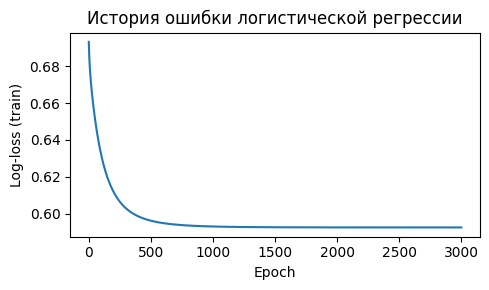

Лучший порог по F1 на валидации: 0.22
F1 при этом пороге: 0.6153846153846153


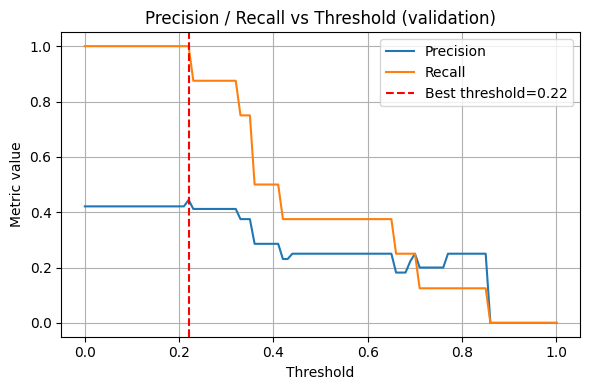

=== Logistic Regression (thr=0.22) (test) ===
Accuracy : 0.4000
Precision: 0.4000
Recall   : 1.0000
F1       : 0.5714
ROC-AUC  : 0.4479
Confusion matrix (rows: true [0,1]; cols: pred [0,1]):
[[ 0 12]
 [ 0  8]]



In [22]:
def add_intercept(X):
    X = np.asarray(X).astype(float)
    n = X.shape[0]
    ones = np.ones((n, 1), dtype=float)
    return np.hstack([ones, X])

class LogisticRegressionGD:
    def __init__(self, lr=0.1, n_epochs=5000):
        self.lr = lr
        self.n_epochs = n_epochs
        self.w = None
        self.loss_history_ = []
    @staticmethod
    def _sigmoid(z):
        z = np.clip(z, -500, 500)
        return 1.0 / (1.0 + np.exp(-z))
    def fit(self, X, y):
        X = add_intercept(X)
        y = np.asarray(y).astype(float)
        n_samples, n_features = X.shape
        self.w = np.zeros(n_features, dtype=float)
        self.loss_history_ = []
        for epoch in range(self.n_epochs):
            z = X @ self.w
            p = self._sigmoid(z)
            eps = 1e-15
            loss = -np.mean(y * np.log(p + eps) + (1 - y) * np.log(1 - p + eps))
            self.loss_history_.append(loss)
            grad = (X.T @ (p - y)) / n_samples
            self.w -= self.lr * grad
        return self
    def predict_proba(self, X):
        X = add_intercept(X)
        z = X @ self.w
        p = self._sigmoid(z)
        return np.vstack([1 - p, p]).T
    def predict(self, X, threshold=0.5):
        probs = self.predict_proba(X)
        pos = probs[:, 1]
        return (pos >= threshold).astype(int)

logreg = LogisticRegressionGD(lr=0.1, n_epochs=3000)
logreg.fit(X_train, y_train)

plt.figure(figsize=(5, 3))
plt.plot(logreg.loss_history_)
plt.xlabel('Epoch')
plt.ylabel('Log-loss (train)')
plt.title('История ошибки логистической регрессии')
plt.tight_layout()
plt.show()

y_val_score_lr = logreg.predict_proba(X_val)[:, 1]
thresholds = np.linspace(0.0, 1.0, 101)
precisions = []
recalls = []
f1s = []
for t in thresholds:
    y_val_pred_t = (y_val_score_lr >= t).astype(int)
    p = precision_score(y_val, y_val_pred_t)
    r = recall_score(y_val, y_val_pred_t)
    f1 = f1_score(y_val, y_val_pred_t)
    precisions.append(p)
    recalls.append(r)
    f1s.append(f1)
precisions = np.array(precisions)
recalls = np.array(recalls)
f1s = np.array(f1s)
best_idx = np.argmax(f1s)
best_threshold = thresholds[best_idx]
print('Лучший порог по F1 на валидации:', best_threshold)
print('F1 при этом пороге:', f1s[best_idx])

plt.figure(figsize=(6, 4))
plt.plot(thresholds, precisions, label='Precision')
plt.plot(thresholds, recalls, label='Recall')
plt.axvline(best_threshold, color='red', linestyle='--', label=f'Best threshold={best_threshold:.2f}')
plt.xlabel('Threshold')
plt.ylabel('Metric value')
plt.title('Precision / Recall vs Threshold (validation)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

y_test_score_lr = logreg.predict_proba(X_test)[:, 1]
y_test_pred_lr = (y_test_score_lr >= best_threshold).astype(int)
lr_results = evaluate_model(y_test, y_test_pred_lr, y_test_score_lr, model_name=f'Logistic Regression (thr={best_threshold:.2f}) (test)')

## 4. Итоговое сравнение моделей на тестовой выборке

Соберём метрики всех моделей (baseline, Naive Bayes, k-NN, Logistic Regression) в одну таблицу и выберем лучшую по различным метрикам.

In [23]:
all_results = []
all_results.append(baseline_results)
all_results.append(nb_results)
all_results.append(knn_results)
all_results.append(lr_results)

results_df = pd.DataFrame(all_results)
results_df = results_df.set_index('model').sort_values('roc_auc', ascending=False)
display(results_df)

print('\nЛучшая модель по ROC-AUC:', results_df.index[0])
print('Лучшая модель по F1:', results_df['f1'].idxmax())
print('Лучшая модель по accuracy:', results_df['accuracy'].idxmax())

,accuracy,precision,recall,f1,roc_auc
model,,,,,
k-NN (k=1) (test),0.55,0.466667,0.875,0.608696,0.645833
Baseline (most frequent),0.40,0.400000,1.000,0.571429,0.593750
Naive Bayes (test),0.45,0.400000,0.750,0.521739,0.500000
Logistic Regression (thr=0.22) (test),0.40,0.400000,1.000,0.571429,0.447917



Лучшая модель по ROC-AUC: k-NN (k=1) (test)
Лучшая модель по F1: k-NN (k=1) (test)
Лучшая модель по accuracy: k-NN (k=1) (test)


## Выводы

1. Тривиальный классификатор задаёт нижнюю границу качества.
2. Наивный Байес (Bernoulli) хорошо работает на бинарных признаках и часто превосходит baseline.
3. k-NN учитывает локальную структуру; выбор k сильно влияет на качество.
4. Логистическая регрессия даёт вероятностный прогноз, выбор порога по F1 может значительно улучшить баланс precision/recall.
5. Окончательный выбор модели зависит от приоритетной метрики и требований задачи.